In [3]:
%load_ext autoreload
%autoreload 2
from resample import subsample_subdataset
import numpy as np
from utils import evaluate, fair_check

from pyhealth.datasets import MIMIC3Dataset

SENS_KEY = 'gender'
root = '/data/qf31/FBen/mimic-iii-clinical-database-1.4'
mimic3base = MIMIC3Dataset(
    root=root,
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"], # PRESCRIPTIONS
    # map all NDC codes to ATC 3-rd level codes in these tables
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
    dev=True,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from pyhealth.datasets import MIMIC3Dataset
mimic3base = MIMIC3Dataset(
    root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
    # map all NDC codes to ATC 3-rd level codes in these tables
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
    dev=True,
)

In [12]:
from pyhealth.tasks import drug_recommendation_mimic3_fn, mortality_prediction_mimic3_fn, readmission_prediction_mimic3_fn
from pyhealth.datasets import split_by_patient, get_dataloader
from tasks import add_feature
#from tasks import drug_recommendation_mimic3_fn
mimic3sample = mimic3base.set_task(task_fn=mortality_prediction_mimic3_fn) # use default task
mimic3sample = add_feature(mimic3sample, mimic3base, [SENS_KEY])
train_ds, val_ds, test_ds = split_by_patient(mimic3sample, [0.6, 0.2, 0.2])

# create dataloaders (torch.data.DataLoader)
train_loader = get_dataloader(train_ds, batch_size=3200, shuffle=True)
val_loader = get_dataloader(val_ds, batch_size=3200, shuffle=False)
test_loader = get_dataloader(test_ds, batch_size=3200, shuffle=False)

Generating samples for mortality_prediction_mimic3_fn: 100%|██████████| 5000/5000 [00:00<00:00, 231829.41it/s]


In [13]:
train_ds.__dir__()

['dataset',
 'indices',
 '__module__',
 '__annotations__',
 '__doc__',
 '__init__',
 '__getitem__',
 '__len__',
 '__orig_bases__',
 '__parameters__',
 '__add__',
 '__dict__',
 '__weakref__',
 '__slots__',
 '__new__',
 '__class_getitem__',
 '__init_subclass__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [3]:
mimic3sample.samples[0].keys()

dict_keys(['visit_id', 'patient_id', 'conditions', 'procedures', 'drugs', 'label', 'gender', 'ethnicity'])

In [4]:
getattr(mimic3base.patients['10'], 'gender')

'F'

In [4]:
mimic3sample.get_all_tokens(key='gender', remove_duplicates=False, sort=False)

['F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M'

In [6]:
mimic3sample.input_info

{'visit_id': {'type': str, 'dim': 0},
 'patient_id': {'type': str, 'dim': 0},
 'conditions': {'type': str, 'dim': 3},
 'procedures': {'type': str, 'dim': 3},
 'drugs': {'type': str, 'dim': 3},
 'label': {'type': int, 'dim': 0},
 'gender': {'type': str, 'dim': 0},
 'ethnicity': {'type': str, 'dim': 0}}

In [6]:
from pyhealth.models import Transformer
from models import Adv_Transformer,Laftr_Transformer, LNL_Transformer, CFair_Transformer, LNL_Trainer
model = LNL_Transformer(
    dataset=mimic3sample,# the dataset should provide sens feat
    feature_keys=["conditions", "procedures", "drugs"], # the model should specify the sens feat
    label_key="label",
    sens_key='gender',
    mode="binary",
    sens_mode = 'binary',
    #fair_coeff=0.0,
    #model_var='laftr-dp'
    # the model should provide sensitive attribute
)

set binary mode to multiclass
set binary sens mode to multiclass


In [13]:
new_list = [_ for _ in list(model.named_parameters()) if 'sens_fc' not in _[0]]
new_list

[('_dummy_param',
  Parameter containing:
  tensor([], requires_grad=True)),
 ('embeddings.conditions.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2991, -1.1321, -0.5520,  ..., -1.4299,  0.5636, -0.2250],
          [ 0.6280, -0.7186, -1.4664,  ...,  0.3803, -0.8594, -1.4790],
          ...,
          [-0.7312,  0.7167,  1.4183,  ..., -0.9104,  0.7194, -0.4060],
          [ 0.8302,  0.0649,  0.3679,  ...,  1.7737, -0.7138, -1.0214],
          [-0.6989, -1.6174,  0.6055,  ..., -0.4188, -2.4469,  0.4839]],
         requires_grad=True)),
 ('embeddings.procedures.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 1.2388, -0.1898,  2.4136,  ...,  0.7203,  1.9647,  1.1141],
          [ 0.1445,  0.4033,  0.7733,  ...,  0.2681, -0.0702,  0.5828],
          ...,
          [-0.6485,  1.0995,  0.4942,  ..., -1.1189, -0.9046,  0.3469],
          [-1.2243, -0.36

In [8]:
model.sens_tokenizer.vocabulary.token2idx

{'F': 0, 'M': 1}

In [7]:
model.sens_tokenizer.convert_tokens_to_indices(['F', 'F'])

[0, 0]

In [5]:
model.label_tokenizer.get_vocabulary_size()

2

In [14]:
model.prepare_labels(kwargs[model.label_key], model.label_tokenizer)

<function pyhealth.models.base_model.BaseModel.prepare_labels(self, labels: Union[List[str], List[List[str]]], label_tokenizer: pyhealth.tokenizer.Tokenizer) -> torch.Tensor>

In [9]:
model.dataset.__len__()

233

In [40]:
model.dataset.get_all_tokens('gender')[0]

'F'

In [29]:
A = model.dataset.get_all_tokens(model.sens_key, remove_duplicates=False, sort=False)
Y = model.dataset.get_all_tokens(model.label_key, remove_duplicates=False, sort=False)
ttl = model.dataset.__len__()

In [23]:
import torch
torch.empty(3, dtype=torch.long).random_(5)

tensor([4, 2, 3])

In [7]:
trainer = LNL_Trainer(model=model,device='cuda:0', metrics=['roc_auc_macro_ovo'])

LNL_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(657, 128, padding_idx=0)
    (procedures): Embedding(212, 128, padding_idx=0)
    (drugs): Embedding(151, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
         

In [8]:
#trainer = Trainer(model=model,device='cuda:0')
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=200,
    monitor='roc_auc_macro_ovo',#"pr_auc_samples",
    #adv_rate = 10.0,
)

Training:
Batch size: 3200
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.0001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f9fe5515490>
Monitor: roc_auc_macro_ovo
Monitor criterion: max
Epochs: 200



Epoch 0 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-0, step-1 ---
loss: 1.9799, sens_loss: 0.9444
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 172.01it/s]
--- Eval epoch-0, step-1 ---
roc_auc_macro_ovo: 0.8800
loss: 1.1681
New best roc_auc_macro_ovo score (0.8800) at epoch-0, step-1



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 1 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-1, step-2 ---
loss: 1.8341, sens_loss: 0.9425
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.94it/s]
--- Eval epoch-1, step-2 ---
roc_auc_macro_ovo: 0.8800
loss: 1.0621



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 2 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-2, step-3 ---
loss: 1.8770, sens_loss: 0.9283
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.84it/s]
--- Eval epoch-2, step-3 ---
roc_auc_macro_ovo: 0.8800
loss: 0.9620



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 3 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-3, step-4 ---
loss: 1.3291, sens_loss: 0.8362
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.11it/s]
--- Eval epoch-3, step-4 ---
roc_auc_macro_ovo: 0.8800
loss: 0.8679



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 4 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-4, step-5 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


loss: 0.8248, sens_loss: 1.0068
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.02it/s]
--- Eval epoch-4, step-5 ---
roc_auc_macro_ovo: 0.8800
loss: 0.7831



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 5 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-5, step-6 ---
loss: 1.0685, sens_loss: 0.8520
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.87it/s]
--- Eval epoch-5, step-6 ---
roc_auc_macro_ovo: 0.8800
loss: 0.7058



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 6 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-6, step-7 ---
loss: 0.9961, sens_loss: 0.7510
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape 

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.22it/s]
--- Eval epoch-6, step-7 ---
roc_auc_macro_ovo: 0.8800
loss: 0.6350



torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 7 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-7, step-8 ---
loss: 1.0551, sens_loss: 0.7697
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 142.67it/s]
--- Eval epoch-7, step-8 ---
roc_auc_macro_ovo: 0.8400
loss: 0.5701



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 8 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-8, step-9 ---
loss: 0.8571, sens_loss: 0.7746
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 138.04it/s]
--- Eval epoch-8, step-9 ---
roc_auc_macro_ovo: 0.8000
loss: 0.5112



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 9 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-9, step-10 ---
loss: 0.9065, sens_loss: 0.7437


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 163.10it/s]
--- Eval epoch-9, step-10 ---
roc_auc_macro_ovo: 0.7200
loss: 0.4579



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 10 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-10, step-11 ---
loss: 0.7508, sens_loss: 0.7958
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 163.01it/s]
--- Eval epoch-10, step-11 ---
roc_auc_macro_ovo: 0.7200
loss: 0.4109



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 11 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-11, step-12 ---
loss: 0.8856, sens_loss: 0.6857
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.86it/s]
--- Eval epoch-11, step-12 ---
roc_auc_macro_ovo: 0.7200
loss: 0.3698



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 12 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-12, step-13 ---
loss: 0.7006, sens_loss: 0.7804
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.79it/s]
--- Eval epoch-12, step-13 ---
roc_auc_macro_ovo: 0.7200
loss: 0.3340



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 13 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-13, step-14 ---
loss: 0.5127, sens_loss: 0.6541
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.23it/s]
--- Eval epoch-13, step-14 ---
roc_auc_macro_ovo: 0.7200
loss: 0.3039



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 14 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-14, step-15 ---
loss: 0.6802, sens_loss: 0.5871
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 162.69it/s]
--- Eval epoch-14, step-15 ---
roc_auc_macro_ovo: 0.7200
loss: 0.2790



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 15 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-15, step-16 ---
loss: 0.5007, sens_loss: 0.6997


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 152.20it/s]
--- Eval epoch-15, step-16 ---
roc_auc_macro_ovo: 0.6400
loss: 0.2589



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 16 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-16, step-17 ---
loss: 0.4392, sens_loss: 0.5403
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.68it/s]
--- Eval epoch-16, step-17 ---
roc_auc_macro_ovo: 0.6400
loss: 0.2428



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 17 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-17, step-18 ---
loss: 0.6539, sens_loss: 0.6258
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 144.34it/s]
--- Eval epoch-17, step-18 ---
roc_auc_macro_ovo: 0.6400
loss: 0.2299



Epoch 18 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-18, step-19 ---
loss: 0.4866, sens_loss: 0.5038
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 156.42it/s]
--- Eval epoch-18, step-19 ---
roc_auc_macro_ovo: 0.6400


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


loss: 0.2201



Epoch 19 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-19, step-20 ---
loss: 0.4071, sens_loss: 0.5878
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 170.51it/s]
--- Eval epoch-19, step-20 ---
roc_auc_macro_ovo: 0.6400
loss: 0.2132



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 20 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-20, step-21 ---
loss: 0.3986, sens_loss: 0.5481
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.22it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-20, step-21 ---
roc_auc_macro_ovo: 0.6400
loss: 0.2084



Epoch 21 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-21, step-22 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


loss: 0.3807, sens_loss: 0.5347
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 176.28it/s]
--- Eval epoch-21, step-22 ---
roc_auc_macro_ovo: 0.6400
loss: 0.2057



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 22 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-22, step-23 ---
loss: 0.3971, sens_loss: 0.5479


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 161.08it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-22, step-23 ---
roc_auc_macro_ovo: 0.6400
loss: 0.2047



Epoch 23 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-23, step-24 ---
loss: 0.4226, sens_loss: 0.5756
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.24it/s]
--- Eval epoch-23, step-24 ---
roc_auc_macro_ovo: 0.6400
loss: 0.2047



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 24 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-24, step-25 ---
loss: 0.3772, sens_loss: 0.6140
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 136.18it/s]
--- Eval epoch-24, step-25 ---
roc_auc_macro_ovo: 0.6000


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


loss: 0.2058



Epoch 25 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-25, step-26 ---
loss: 0.3054, sens_loss: 0.5771
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.56it/s]
--- Eval epoch-25, step-26 ---
roc_auc_macro_ovo: 0.6000
loss: 0.2076



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 26 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-26, step-27 ---
loss: 0.2778, sens_loss: 0.5788
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.24it/s]
--- Eval epoch-26, step-27 ---
roc_auc_macro_ovo: 0.6000
loss: 0.2100



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 27 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-27, step-28 ---
loss: 0.1926, sens_loss: 0.5566
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 169.10it/s]
--- Eval epoch-27, step-28 ---
roc_auc_macro_ovo: 0.6000
loss: 0.2129



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 28 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-28, step-29 ---
loss: 0.2716, sens_loss: 0.4788


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.23it/s]
--- Eval epoch-28, step-29 ---
roc_auc_macro_ovo: 0.6000
loss: 0.2161



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 29 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-29, step-30 ---
loss: 0.2653, sens_loss: 0.5409


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 164.13it/s]
--- Eval epoch-29, step-30 ---
roc_auc_macro_ovo: 0.6000
loss: 0.2194



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 30 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-30, step-31 ---
loss: 0.2557, sens_loss: 0.4959


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 159.57it/s]
--- Eval epoch-30, step-31 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2229



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 31 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-31, step-32 ---
loss: 0.2681, sens_loss: 0.4301


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.18it/s]
--- Eval epoch-31, step-32 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2263



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 32 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])


--- Train epoch-32, step-33 ---
loss: 0.3184, sens_loss: 0.5191
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape 

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 148.43it/s]
--- Eval epoch-32, step-33 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2297



torch.Size([26, 2])


Epoch 33 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-33, step-34 ---
loss: 0.1872, sens_loss: 0.3850
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.02it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-33, step-34 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2331



Epoch 34 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-34, step-35 ---
loss: 0.1990, sens_loss: 0.3899


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 147.34it/s]
--- Eval epoch-34, step-35 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2365



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 35 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-35, step-36 ---
loss: 0.3259, sens_loss: 0.5248
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 159.87it/s]
--- Eval epoch-35, step-36 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2399



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 36 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-36, step-37 ---
loss: 0.3714, sens_loss: 0.4376
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 102.13it/s]
--- Eval epoch-36, step-37 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2434


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 37 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-37, step-38 ---
loss: 0.2854, sens_loss: 0.4941
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.47it/s]
--- Eval epoch-37, step-38 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2469



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 38 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-38, step-39 ---
loss: 0.2379, sens_loss: 0.4047
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 147.94it/s]
--- Eval epoch-38, step-39 ---
roc_auc_macro_ovo: 0.5600
loss: 0.2505



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 39 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-39, step-40 ---
loss: 0.2190, sens_loss: 0.4077
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 152.49it/s]
--- Eval epoch-39, step-40 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2538



Epoch 40 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-40, step-41 ---
loss: 0.2126, sens_loss: 0.4436
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.83it/s]
--- Eval epoch-40, step-41 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2570



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 41 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-41, step-42 ---
loss: 0.2133, sens_loss: 0.4311


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.39it/s]
--- Eval epoch-41, step-42 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2599



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 42 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-42, step-43 ---
loss: 0.2177, sens_loss: 0.3316


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 145.96it/s]
--- Eval epoch-42, step-43 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2626



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 43 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-43, step-44 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


loss: 0.1033, sens_loss: 0.3725
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 140.54it/s]
--- Eval epoch-43, step-44 ---


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


roc_auc_macro_ovo: 0.5200
loss: 0.2652



Epoch 44 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-44, step-45 ---
loss: 0.2676, sens_loss: 0.4178
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 144.19it/s]
--- Eval epoch-44, step-45 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2678


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 45 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-45, step-46 ---
loss: 0.1331, sens_loss: 0.3521
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape 

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 131.06it/s]
--- Eval epoch-45, step-46 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2701



torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 46 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-46, step-47 ---
loss: 0.1653, sens_loss: 0.4077
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.46it/s]
--- Eval epoch-46, step-47 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2723



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 47 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-47, step-48 ---
loss: 0.2357, sens_loss: 0.3577


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.30it/s]
--- Eval epoch-47, step-48 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2744



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 48 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-48, step-49 ---
loss: 0.1312, sens_loss: 0.3444
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 152.57it/s]
--- Eval epoch-48, step-49 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2764



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 49 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-49, step-50 ---
loss: 0.4119, sens_loss: 0.3096
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.53it/s]
--- Eval epoch-49, step-50 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2783



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 50 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-50, step-51 ---
loss: 0.1128, sens_loss: 0.3368
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 171.57it/s]
--- Eval epoch-50, step-51 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2803



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 51 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-51, step-52 ---
loss: 0.1495, sens_loss: 0.3732
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.87it/s]
--- Eval epoch-51, step-52 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2821



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 52 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-52, step-53 ---
loss: 0.0805, sens_loss: 0.3701
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 170.68it/s]
--- Eval epoch-52, step-53 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2838



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 53 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-53, step-54 ---
loss: 0.1754, sens_loss: 0.3351


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 167.48it/s]
--- Eval epoch-53, step-54 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2853



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 54 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-54, step-55 ---
loss: 0.1011, sens_loss: 0.3505


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.91it/s]
--- Eval epoch-54, step-55 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2868



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 55 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-55, step-56 ---
loss: 0.2321, sens_loss: 0.3479
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 173.18it/s]
--- Eval epoch-55, step-56 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2883



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 56 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-56, step-57 ---
loss: 0.1524, sens_loss: 0.3909
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.54it/s]
--- Eval epoch-56, step-57 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2897



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 57 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-57, step-58 ---
loss: 0.1408, sens_loss: 0.3111
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 171.76it/s]
--- Eval epoch-57, step-58 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2911



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 58 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-58, step-59 ---
loss: 0.1027, sens_loss: 0.3228
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 131.59it/s]
--- Eval epoch-58, step-59 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2924



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 59 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-59, step-60 ---
loss: 0.2298, sens_loss: 0.3602
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 140.96it/s]
--- Eval epoch-59, step-60 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2937



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 60 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-60, step-61 ---
loss: 0.1043, sens_loss: 0.3394
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.80it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-60, step-61 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2951



Epoch 61 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-61, step-62 ---
loss: 0.2069, sens_loss: 0.3208


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 125.48it/s]
--- Eval epoch-61, step-62 ---
roc_auc_macro_ovo: 0.5200
loss: 0.2963



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 62 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-62, step-63 ---
loss: 0.1266, sens_loss: 0.3442
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 142.95it/s]
--- Eval epoch-62, step-63 ---
roc_auc_macro_ovo: 0.4800
loss: 0.2976



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 63 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-63, step-64 ---
loss: 0.0861, sens_loss: 0.3369
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 122.09it/s]
--- Eval epoch-63, step-64 ---
roc_auc_macro_ovo: 0.4800
loss: 0.2989



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 64 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-64, step-65 ---
loss: 0.1362, sens_loss: 0.2848
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 122.00it/s]
--- Eval epoch-64, step-65 ---
roc_auc_macro_ovo: 0.4800
loss: 0.3001



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 65 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-65, step-66 ---
loss: 0.0829, sens_loss: 0.2890


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 138.47it/s]
--- Eval epoch-65, step-66 ---
roc_auc_macro_ovo: 0.4800
loss: 0.3011



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 66 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-66, step-67 ---
loss: 0.1092, sens_loss: 0.2885
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 127.83it/s]
--- Eval epoch-66, step-67 ---
roc_auc_macro_ovo: 0.4800
loss: 0.3021



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 67 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-67, step-68 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


loss: 0.1201, sens_loss: 0.2916
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 138.93it/s]
--- Eval epoch-67, step-68 ---
roc_auc_macro_ovo: 0.4800
loss: 0.3032



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 68 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-68, step-69 ---
loss: 0.0785, sens_loss: 0.2144
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 143.27it/s]
--- Eval epoch-68, step-69 ---
roc_auc_macro_ovo: 0.4800
loss: 0.3042



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 69 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-69, step-70 ---
loss: 0.1725, sens_loss: 0.2843
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 143.43it/s]
--- Eval epoch-69, step-70 ---
roc_auc_macro_ovo: 0.4800
loss: 0.3050



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 70 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-70, step-71 ---
loss: 0.1575, sens_loss: 0.2646


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 148.30it/s]
--- Eval epoch-70, step-71 ---
roc_auc_macro_ovo: 0.4800
loss: 0.3059



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 71 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])


--- Train epoch-71, step-72 ---
loss: 0.1556, sens_loss: 0.2564


sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 145.20it/s]
--- Eval epoch-71, step-72 ---
roc_auc_macro_ovo: 0.4800
loss: 0.3069



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 72 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-72, step-73 ---
loss: 0.1649, sens_loss: 0.2389
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.01it/s]
--- Eval epoch-72, step-73 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3081



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 73 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-73, step-74 ---
loss: 0.2154, sens_loss: 0.2870
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.55it/s]
--- Eval epoch-73, step-74 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3092



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 74 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])


--- Train epoch-74, step-75 ---
loss: 0.0612, sens_loss: 0.2532
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.29it/s]
--- Eval epoch-74, step-75 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3104



sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 75 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-75, step-76 ---
loss: 0.1516, sens_loss: 0.3094
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.33it/s]
--- Eval epoch-75, step-76 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3116



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 76 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-76, step-77 ---
loss: 0.0948, sens_loss: 0.2153
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 95.58it/s]
--- Eval epoch-76, step-77 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3128



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 77 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-77, step-78 ---
loss: 0.1344, sens_loss: 0.3188
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 143.69it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-77, step-78 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3139



Epoch 78 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-78, step-79 ---
loss: 0.1858, sens_loss: 0.2980
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 148.61it/s]
--- Eval epoch-78, step-79 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3152



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 79 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-79, step-80 ---
loss: 0.1300, sens_loss: 0.2414
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape 

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 130.22it/s]
--- Eval epoch-79, step-80 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3163



torch.Size([26, 2])


Epoch 80 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-80, step-81 ---
loss: 0.0966, sens_loss: 0.2057
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 144.89it/s]
--- Eval epoch-80, step-81 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3173



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 81 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-81, step-82 ---
loss: 0.0824, sens_loss: 0.2365
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 139.11it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-81, step-82 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3184



Epoch 82 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-82, step-83 ---
loss: 0.2187, sens_loss: 0.2208
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 149.37it/s]
--- Eval epoch-82, step-83 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3193



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 83 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-83, step-84 ---
loss: 0.0247, sens_loss: 0.2483
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.61it/s]
--- Eval epoch-83, step-84 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3203



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 84 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-84, step-85 ---
loss: 0.0637, sens_loss: 0.2746
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 155.22it/s]
--- Eval epoch-84, step-85 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3213



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 85 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-85, step-86 ---
loss: 0.1273, sens_loss: 0.2135
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 140.03it/s]
--- Eval epoch-85, step-86 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3224



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 86 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-86, step-87 ---
loss: 0.0546, sens_loss: 0.2266
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 142.32it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-86, step-87 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3234



Epoch 87 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-87, step-88 ---
loss: 0.1379, sens_loss: 0.1896
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 139.73it/s]
--- Eval epoch-87, step-88 ---
roc_auc_macro_ovo: 0.4400
loss: 0.3245



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 88 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-88, step-89 ---
loss: 0.1578, sens_loss: 0.2290
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.62it/s]
--- Eval epoch-88, step-89 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3255



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 89 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-89, step-90 ---
loss: 0.0383, sens_loss: 0.2824
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.94it/s]
--- Eval epoch-89, step-90 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3266



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 90 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-90, step-91 ---
loss: 0.0598, sens_loss: 0.2104
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 108.47it/s]
--- Eval epoch-90, step-91 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3277



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 91 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-91, step-92 ---
loss: 0.0883, sens_loss: 0.2243
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.65it/s]
--- Eval epoch-91, step-92 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3288



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 92 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape 

--- Train epoch-92, step-93 ---
loss: 0.0346, sens_loss: 0.1998
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 162.38it/s]
--- Eval epoch-92, step-93 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3298



torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 93 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-93, step-94 ---
loss: 0.0364, sens_loss: 0.2168
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.54it/s]
--- Eval epoch-93, step-94 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3309



Epoch 94 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-94, step-95 ---
loss: 0.1250, sens_loss: 0.1939
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 135.41it/s]
--- Eval epoch-94, step-95 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3320



Epoch 95 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-95, step-96 ---
loss: 0.0635, sens_loss: 0.1870
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.04it/s]
--- Eval epoch-95, step-96 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3330



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 96 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-96, step-97 ---
loss: 0.0642, sens_loss: 0.2199
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 155.76it/s]
--- Eval epoch-96, step-97 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


roc_auc_macro_ovo: 0.4000
loss: 0.3339



Epoch 97 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-97, step-98 ---
loss: 0.0670, sens_loss: 0.2324
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 161.61it/s]
--- Eval epoch-97, step-98 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3347



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 98 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-98, step-99 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


loss: 0.1985, sens_loss: 0.2162
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([26, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 131.24it/s]
--- Eval epoch-98, step-99 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3357



sens_logits.shape torch.Size([26, 2])


Epoch 99 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-99, step-100 ---
loss: 0.0385, sens_loss: 0.2120
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.98it/s]
--- Eval epoch-99, step-100 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3366



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 100 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-100, step-101 ---
loss: 0.0265, sens_loss: 0.2270
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.63it/s]
--- Eval epoch-100, step-101 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3376



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 101 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-101, step-102 ---
loss: 0.0459, sens_loss: 0.1882
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 161.04it/s]
--- Eval epoch-101, step-102 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3385


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 102 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-102, step-103 ---
loss: 0.1107, sens_loss: 0.2057


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 156.22it/s]
--- Eval epoch-102, step-103 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3392



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 103 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-103, step-104 ---
loss: 0.1233, sens_loss: 0.1776
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.15it/s]
--- Eval epoch-103, step-104 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3400



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 104 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-104, step-105 ---
loss: 0.0526, sens_loss: 0.2833
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.90it/s]
--- Eval epoch-104, step-105 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3409



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 105 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-105, step-106 ---
loss: 0.1099, sens_loss: 0.1946
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.99it/s]
--- Eval epoch-105, step-106 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3421



Epoch 106 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-106, step-107 ---
loss: 0.0501, sens_loss: 0.2245


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 165.26it/s]
--- Eval epoch-106, step-107 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3432



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 107 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-107, step-108 ---
loss: 0.1198, sens_loss: 0.1869


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 165.48it/s]
--- Eval epoch-107, step-108 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3445



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 108 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-108, step-109 ---
loss: 0.0417, sens_loss: 0.2064


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 164.04it/s]
--- Eval epoch-108, step-109 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3458



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 109 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-109, step-110 ---
loss: 0.0893, sens_loss: 0.2071


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.54it/s]
--- Eval epoch-109, step-110 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3472



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 110 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-110, step-111 ---
loss: 0.0270, sens_loss: 0.1708
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.87it/s]
--- Eval epoch-110, step-111 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3486



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 111 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-111, step-112 ---
loss: 0.0448, sens_loss: 0.2162
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 155.18it/s]
--- Eval epoch-111, step-112 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3501



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 112 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-112, step-113 ---
loss: 0.0771, sens_loss: 0.2205
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.55it/s]
--- Eval epoch-112, step-113 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3514



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 113 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-113, step-114 ---
loss: 0.0698, sens_loss: 0.1895
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 147.06it/s]
--- Eval epoch-113, step-114 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3526



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 114 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-114, step-115 ---
loss: 0.0091, sens_loss: 0.1789
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 138.91it/s]
--- Eval epoch-114, step-115 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3537



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 115 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-115, step-116 ---
loss: 0.0775, sens_loss: 0.1955
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 149.00it/s]
--- Eval epoch-115, step-116 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3548



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 116 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-116, step-117 ---
loss: 0.0233, sens_loss: 0.1781
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 142.49it/s]
--- Eval epoch-116, step-117 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3557



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 117 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-117, step-118 ---
loss: 0.0178, sens_loss: 0.1767
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.02it/s]
--- Eval epoch-117, step-118 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3565



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 118 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-118, step-119 ---
loss: 0.0831, sens_loss: 0.1276
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 130.61it/s]
--- Eval epoch-118, step-119 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3572



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 119 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-119, step-120 ---
loss: 0.0659, sens_loss: 0.1402
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.76it/s]
--- Eval epoch-119, step-120 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3578



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 120 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-120, step-121 ---
loss: 0.0624, sens_loss: 0.2042
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 148.33it/s]
--- Eval epoch-120, step-121 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3584



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 121 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-121, step-122 ---
loss: 0.0206, sens_loss: 0.1614
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 155.37it/s]
--- Eval epoch-121, step-122 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3588


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 122 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-122, step-123 ---
loss: 0.0676, sens_loss: 0.2511
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape 

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.98it/s]
--- Eval epoch-122, step-123 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3594



torch.Size([26, 2])


Epoch 123 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-123, step-124 ---
loss: 0.0143, sens_loss: 0.2598
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 128.28it/s]
--- Eval epoch-123, step-124 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3600



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 124 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-124, step-125 ---
loss: 0.0347, sens_loss: 0.1812
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 126.84it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-124, step-125 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3604



Epoch 125 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-125, step-126 ---
loss: 0.0751, sens_loss: 0.1995
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 145.52it/s]
--- Eval epoch-125, step-126 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3610



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 126 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-126, step-127 ---
loss: 0.0776, sens_loss: 0.1760
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.09it/s]
--- Eval epoch-126, step-127 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3616



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 127 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-127, step-128 ---
loss: 0.0311, sens_loss: 0.1482
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.14it/s]
--- Eval epoch-127, step-128 ---
roc_auc_macro_ovo: 0.4000


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


loss: 0.3622



Epoch 128 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-128, step-129 ---
loss: 0.0060, sens_loss: 0.1512
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 144.64it/s]
--- Eval epoch-128, step-129 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3629



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 129 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape

--- Train epoch-129, step-130 ---
loss: 0.0193, sens_loss: 0.1739
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.69it/s]
--- Eval epoch-129, step-130 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3634



 torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 130 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-130, step-131 ---
loss: 0.0421, sens_loss: 0.1662
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.82it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-130, step-131 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3638



Epoch 131 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])

--- Train epoch-131, step-132 ---
loss: 0.0138, sens_loss: 0.1614
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.66it/s]
--- Eval epoch-131, step-132 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3642




logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 132 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-132, step-133 ---
loss: 0.0193, sens_loss: 0.1506
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 159.01it/s]
--- Eval epoch-132, step-133 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3648


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 133 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-133, step-134 ---
loss: 0.0196, sens_loss: 0.1383
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 168.43it/s]
--- Eval epoch-133, step-134 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3654



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 134 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-134, step-135 ---
loss: 0.0342, sens_loss: 0.1472


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 162.39it/s]
--- Eval epoch-134, step-135 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3662



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 135 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-135, step-136 ---
loss: 0.0189, sens_loss: 0.2748


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 163.20it/s]
--- Eval epoch-135, step-136 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3670



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 136 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-136, step-137 ---
loss: 0.0346, sens_loss: 0.1361
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 170.51it/s]
--- Eval epoch-136, step-137 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3679



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 137 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-137, step-138 ---
loss: 0.0312, sens_loss: 0.1649


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 156.43it/s]
--- Eval epoch-137, step-138 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3686



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 138 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-138, step-139 ---
loss: 0.0160, sens_loss: 0.1964
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 163.35it/s]
--- Eval epoch-138, step-139 ---


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


roc_auc_macro_ovo: 0.4000
loss: 0.3693



Epoch 139 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-139, step-140 ---
loss: 0.0327, sens_loss: 0.1511
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.07it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-139, step-140 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3700



Epoch 140 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-140, step-141 ---
loss: 0.0227, sens_loss: 0.1494
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 147.91it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-140, step-141 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3708



Epoch 141 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-141, step-142 ---
loss: 0.0367, sens_loss: 0.2019
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.22it/s]
--- Eval epoch-141, step-142 ---
roc_auc_macro_ovo: 0.4000


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


loss: 0.3716



Epoch 142 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-142, step-143 ---
loss: 0.0140, sens_loss: 0.1619


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.91it/s]
--- Eval epoch-142, step-143 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3724



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 143 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-143, step-144 ---
loss: 0.0096, sens_loss: 0.1945


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.07it/s]
--- Eval epoch-143, step-144 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3732



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 144 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-144, step-145 ---
loss: 0.0361, sens_loss: 0.1539


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.15it/s]
--- Eval epoch-144, step-145 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3740



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 145 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-145, step-146 ---
loss: 0.0200, sens_loss: 0.1844
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 175.30it/s]
--- Eval epoch-145, step-146 ---


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


roc_auc_macro_ovo: 0.4000
loss: 0.3748



Epoch 146 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-146, step-147 ---
loss: 0.0427, sens_loss: 0.2155


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 177.42it/s]
--- Eval epoch-146, step-147 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3757



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 147 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-147, step-148 ---
loss: 0.0704, sens_loss: 0.1718


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 168.57it/s]
--- Eval epoch-147, step-148 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3769



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 148 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-148, step-149 ---
loss: 0.0102, sens_loss: 0.1658
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 138.64it/s]
--- Eval epoch-148, step-149 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3779



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 149 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape 

--- Train epoch-149, step-150 ---
loss: 0.0102, sens_loss: 0.1362


torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 156.67it/s]
--- Eval epoch-149, step-150 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3790



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 150 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-150, step-151 ---
loss: 0.0265, sens_loss: 0.1419
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 163.80it/s]
--- Eval epoch-150, step-151 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3801



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 151 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape 

--- Train epoch-151, step-152 ---
loss: 0.0322, sens_loss: 0.1501


torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 149.56it/s]
--- Eval epoch-151, step-152 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3810



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 152 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-152, step-153 ---
loss: 0.0167, sens_loss: 0.1643
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.70it/s]
--- Eval epoch-152, step-153 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3819



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 153 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-153, step-154 ---
loss: 0.0191, sens_loss: 0.1225
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.23it/s]
--- Eval epoch-153, step-154 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3827



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 154 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-154, step-155 ---
loss: 0.0344, sens_loss: 0.1279


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 164.08it/s]
--- Eval epoch-154, step-155 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3836



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 155 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-155, step-156 ---
loss: 0.0490, sens_loss: 0.1150


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 167.83it/s]
--- Eval epoch-155, step-156 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3845



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 156 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-156, step-157 ---
loss: 0.0250, sens_loss: 0.1656
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.64it/s]
--- Eval epoch-156, step-157 ---


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


roc_auc_macro_ovo: 0.4000
loss: 0.3852



Epoch 157 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])


--- Train epoch-157, step-158 ---
loss: 0.0413, sens_loss: 0.1158
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 158.74it/s]
--- Eval epoch-157, step-158 ---
roc_auc_macro_ovo: 0.4000


sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


loss: 0.3863



Epoch 158 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-158, step-159 ---
loss: 0.0138, sens_loss: 0.1010
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 168.97it/s]
--- Eval epoch-158, step-159 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3875



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 159 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-159, step-160 ---
loss: 0.0476, sens_loss: 0.1425


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 166.60it/s]
--- Eval epoch-159, step-160 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3887



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 160 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-160, step-161 ---
loss: 0.0235, sens_loss: 0.1242


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 160.41it/s]
--- Eval epoch-160, step-161 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3901



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 161 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-161, step-162 ---
loss: 0.0098, sens_loss: 0.1182
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.67it/s]
--- Eval epoch-161, step-162 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3914



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 162 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-162, step-163 ---
loss: 0.0677, sens_loss: 0.1353
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.71it/s]
--- Eval epoch-162, step-163 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3926



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 163 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-163, step-164 ---
loss: 0.0373, sens_loss: 0.1373
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.60it/s]
--- Eval epoch-163, step-164 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3937



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 164 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-164, step-165 ---
loss: 0.0152, sens_loss: 0.1380
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 163.22it/s]
--- Eval epoch-164, step-165 ---
roc_auc_macro_ovo: 0.4000
loss: 0.3950



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 165 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-165, step-166 ---
loss: 0.0083, sens_loss: 0.1255


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 155.14it/s]
--- Eval epoch-165, step-166 ---
roc_auc_macro_ovo: 0.3600


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


loss: 0.3962



Epoch 166 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-166, step-167 ---
loss: 0.0771, sens_loss: 0.1846
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 162.48it/s]
--- Eval epoch-166, step-167 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3971



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 167 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-167, step-168 ---
loss: 0.0134, sens_loss: 0.1368
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 159.87it/s]
--- Eval epoch-167, step-168 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3981



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 168 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-168, step-169 ---
loss: 0.0434, sens_loss: 0.1128
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.24it/s]
--- Eval epoch-168, step-169 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3990



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 169 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-169, step-170 ---
loss: 0.0158, sens_loss: 0.1578


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 166.93it/s]
--- Eval epoch-169, step-170 ---
roc_auc_macro_ovo: 0.3600
loss: 0.3998



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 170 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-170, step-171 ---
loss: 0.0065, sens_loss: 0.1075


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 173.10it/s]
--- Eval epoch-170, step-171 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4005



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 171 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-171, step-172 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


loss: 0.0165, sens_loss: 0.1047
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 104.90it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-171, step-172 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4011



Epoch 172 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-172, step-173 ---
loss: 0.0041, sens_loss: 0.1416


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 162.43it/s]
--- Eval epoch-172, step-173 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4016


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 173 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-173, step-174 ---
loss: 0.0388, sens_loss: 0.1279


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 158.90it/s]
--- Eval epoch-173, step-174 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4025



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 174 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-174, step-175 ---
loss: 0.0214, sens_loss: 0.1368
Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 125.61it/s]
--- Eval epoch-174, step-175 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4031



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 175 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-175, step-176 ---
loss: 0.0094, sens_loss: 0.1457


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 125.22it/s]
--- Eval epoch-175, step-176 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4038



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 176 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-176, step-177 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


loss: 0.0278, sens_loss: 0.1082
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 161.68it/s]
--- Eval epoch-176, step-177 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4046



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 177 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-177, step-178 ---
loss: 0.0102, sens_loss: 0.1419
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 171.41it/s]
--- Eval epoch-177, step-178 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4054



logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 178 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-178, step-179 ---
loss: 0.0109, sens_loss: 0.1236


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 157.92it/s]
--- Eval epoch-178, step-179 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4061



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 179 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])


--- Train epoch-179, step-180 ---
loss: 0.0115, sens_loss: 0.1497


sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.37it/s]
--- Eval epoch-179, step-180 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4068



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 180 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-180, step-181 ---
loss: 0.0528, sens_loss: 0.1236


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 156.39it/s]
--- Eval epoch-180, step-181 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4073



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 181 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-181, step-182 ---
loss: 0.0080, sens_loss: 0.1436
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 156.73it/s]
--- Eval epoch-181, step-182 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4078



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 182 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-182, step-183 ---
loss: 0.0095, sens_loss: 0.1255


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 148.31it/s]
--- Eval epoch-182, step-183 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4083


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 183 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-183, step-184 ---


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


loss: 0.0160, sens_loss: 0.1088
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 135.76it/s]
--- Eval epoch-183, step-184 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4089



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 184 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-184, step-185 ---
loss: 0.0120, sens_loss: 0.1183
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 136.51it/s]
--- Eval epoch-184, step-185 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4096



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 185 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-185, step-186 ---
loss: 0.0073, sens_loss: 0.0990
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.41it/s]
--- Eval epoch-185, step-186 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4103



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 186 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-186, step-187 ---
loss: 0.0492, sens_loss: 0.1422


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.76it/s]
--- Eval epoch-186, step-187 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4107



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 187 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-187, step-188 ---
loss: 0.0112, sens_loss: 0.1136


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.41it/s]
--- Eval epoch-187, step-188 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4111



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 188 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-188, step-189 ---
loss: 0.0134, sens_loss: 0.0929


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 150.31it/s]
--- Eval epoch-188, step-189 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4117



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 189 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-189, step-190 ---
loss: 0.0078, sens_loss: 0.0833


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.63it/s]
--- Eval epoch-189, step-190 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4122



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 190 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-190, step-191 ---
loss: 0.0048, sens_loss: 0.1346
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 151.88it/s]
--- Eval epoch-190, step-191 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4127



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 191 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-191, step-192 ---
loss: 0.0067, sens_loss: 0.1356


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 133.98it/s]
--- Eval epoch-191, step-192 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4132



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 192 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-192, step-193 ---
loss: 0.0069, sens_loss: 0.1456


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.60it/s]
--- Eval epoch-192, step-193 ---
roc_auc_macro_ovo: 0.3200
loss: 0.4137



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 193 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-193, step-194 ---
loss: 0.0052, sens_loss: 0.1129


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 146.28it/s]
--- Eval epoch-193, step-194 ---
roc_auc_macro_ovo: 0.2800
loss: 0.4143



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 194 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

--- Train epoch-194, step-195 ---
loss: 0.0168, sens_loss: 0.1142


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 142.93it/s]
--- Eval epoch-194, step-195 ---
roc_auc_macro_ovo: 0.2800
loss: 0.4149



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 195 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-195, step-196 ---
loss: 0.0086, sens_loss: 0.1745


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 159.27it/s]
--- Eval epoch-195, step-196 ---
roc_auc_macro_ovo: 0.2800
loss: 0.4156



logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 196 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-196, step-197 ---
loss: 0.0136, sens_loss: 0.1324
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.98it/s]
--- Eval epoch-196, step-197 ---
roc_auc_macro_ovo: 0.2800


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


loss: 0.4162



Epoch 197 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-197, step-198 ---
loss: 0.0121, sens_loss: 0.1172
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 149.09it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])



--- Eval epoch-197, step-198 ---
roc_auc_macro_ovo: 0.2800
loss: 0.4170



Epoch 198 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-198, step-199 ---
loss: 0.0314, sens_loss: 0.0851
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 153.77it/s]
--- Eval epoch-198, step-199 ---
roc_auc_macro_ovo: 0.2800
loss: 0.4177


logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


Epoch 199 / 200:   0%|          | 0/1 [00:00<?, ?it/s]

logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])
logits.shape torch.Size([80, 2])
sens_logits.shape torch.Size([80, 2])


--- Train epoch-199, step-200 ---
loss: 0.0072, sens_loss: 0.1005
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 154.49it/s]
--- Eval epoch-199, step-200 ---
roc_auc_macro_ovo: 0.2800
loss: 0.4184
Loaded best model


logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


In [10]:
from utils import fair_check, evaluate
evaluate(trainer, test_loader)

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 73.93it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


{'roc_auc_macro_ovo': 0.6, 'loss': 1.501630187034607}

In [11]:
from utils import fair_check, evaluate
evaluate(trainer, test_loader)

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 141.57it/s]

logits.shape torch.Size([26, 2])
sens_logits.shape torch.Size([26, 2])


{'roc_auc_macro_ovo': 0.6, 'loss': 1.501630187034607}

In [9]:
from utils import fair_check
fair_check(trainer, test_loader)

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 177.41it/s]


{'roc_auc': 0.32962962962962955}

In [18]:
from utils import fair_check
fair_check(trainer, test_loader)

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 188.66it/s]


{'roc_auc': 0.03872053872053871}

In [31]:
final_result = {}
for subsample_rate in [0.0, 0.25, 0.5, 0.75, 1.0]:
    final_result[subsample_rate] = {'auc':[], 'auc_diff': []}
    for _ in range(3):
        model = Adv_Transformer(
            dataset=mimic3sample,# the dataset should provide sens feat
            feature_keys=["conditions", "procedures"], # the model should specify the sens feat
            label_key="drugs",
            sens_key='gender',
            mode="multilabel",
            sens_mode = 'multiclass',
            # the model should provide sensitive attribute   
        )
        trainer = Trainer(model=model,device='cuda:0')

        #trainer = Trainer(model=model,device='cuda:0')
        trainer.train(
            train_dataloader= get_dataloader(subsample_subdataset(train_ds, 'gender', subsample_rate), batch_size=32, shuffle=True),
            val_dataloader=val_loader,
            epochs=1,
            monitor="pr_auc_samples",
            #adv_rate = subsample_rate,
        )
        
        final_result[subsample_rate]['auc'] += [evaluate(trainer, test_loader)['pr_auc_samples']]
        final_result[subsample_rate]['auc_diff'] += [fair_check(trainer, test_loader)['pr_auc_samples']]

    final_result[subsample_rate]['auc'] = {'mean': np.mean(final_result[subsample_rate]['auc']), 'std': np.std(final_result[subsample_rate]['auc'])}
    final_result[subsample_rate]['auc_diff'] = {'mean': np.mean(final_result[subsample_rate]['auc_diff']), 'std': np.std(final_result[subsample_rate]['auc_diff'])}



Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=1

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0005
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.32it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3443
loss: 0.6593
New best pr_auc_samples score (0.3443) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 144.21it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0498
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 174.91it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3190
loss: 0.7097
New best pr_auc_samples score (0.3190) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.65it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0407
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.23it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3387
loss: 0.7055
New best pr_auc_samples score (0.3387) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 146.96it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0234
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.27it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3554
loss: 0.6835
New best pr_auc_samples score (0.3554) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 147.00it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0253
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 133.28it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3074
loss: 0.7304
New best pr_auc_samples score (0.3074) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.83it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0102
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 182.16it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3488
loss: 0.7025
New best pr_auc_samples score (0.3488) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 146.67it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 0.9957
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 178.63it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3522
loss: 0.6790
New best pr_auc_samples score (0.3522) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 144.41it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0567
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 179.66it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3192
loss: 0.6907
New best pr_auc_samples score (0.3192) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.85it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0248
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 142.65it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3222
loss: 0.6956
New best pr_auc_samples score (0.3222) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 143.96it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0544
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 180.34it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3168
loss: 0.7513
New best pr_auc_samples score (0.3168) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 144.97it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0383
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 176.64it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3055
loss: 0.7355
New best pr_auc_samples score (0.3055) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 144.11it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0025
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.48it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3541
loss: 0.6986
New best pr_auc_samples score (0.3541) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 146.24it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0599
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 172.71it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3232
loss: 0.6860
New best pr_auc_samples score (0.3232) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 147.57it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0018
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.79it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3460
loss: 0.6723
New best pr_auc_samples score (0.3460) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 146.83it/s]
Adv_Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(917, 128, padding_idx=0)
    (procedures): Embedding(305, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_featur

Epoch 0 / 1:   0%|          | 0/7 [00:00<?, ?it/s]

--- Train epoch-0, step-7 ---
loss: 1.0493
Evaluation: 100%|██████████| 1/1 [00:00<00:00, 181.97it/s]
--- Eval epoch-0, step-7 ---
pr_auc_samples: 0.3101
loss: 0.7444
New best pr_auc_samples score (0.3101) at epoch-0, step-7
Loaded best model
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.25it/s]


In [10]:
(final_result[0.0]['auc'])

{'mean': 0.30370512899526597, 'std': 0.026583837395578767}

In [16]:
(final_result[0.0]['auc_diff'])

{'mean': 0.09379999239964172, 'std': 0.020344631310541664}

In [12]:
torch.save(final_result, 'adv_test_result')

In [12]:
import torch

In [13]:
final_result = torch.load('subsample_test_result')

In [14]:
from matplotlib import pyplot as plt

In [15]:
auc_list = [final_result[adv_rate]['auc']['mean'] for adv_rate in final_result.keys()]
auc_std_list = [final_result[adv_rate]['auc']['std'] for adv_rate in final_result.keys()]

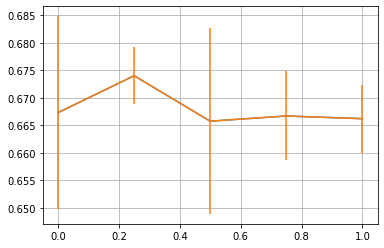

In [16]:
plt.plot(list(final_result.keys()), auc_list)
plt.errorbar(final_result.keys(), auc_list, yerr=auc_std_list, label='both limits (default)')
#plt.xscale('log')
plt.grid()

In [17]:
auc_diff_list = [final_result[adv_rate]['auc_diff']['mean'] for adv_rate in final_result.keys()]
auc__diff_std_list = [final_result[adv_rate]['auc_diff']['std'] for adv_rate in final_result.keys()]

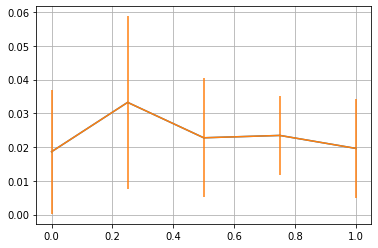

In [18]:
plt.plot(list(final_result.keys()), auc_diff_list)
plt.errorbar(final_result.keys(), auc_diff_list, yerr=auc__diff_std_list, label='both limits (default)')
#plt.xscale('log')
plt.grid()

In [ ]:
[0.0, 0.1, 1.0, 10.0]

In [ ]:
train_ds = subsample_subdataset(train_ds)
train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True)